In [86]:
import pandas as pd
import numpy as np
from numpy.random import randint
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    OneHotEncoder,
    QuantileTransformer,
    RobustScaler,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    balanced_accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
    make_scorer,
    cohen_kappa_score,
    f1_score
)
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from imblearn import pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier

In [87]:
sns.set_theme()

colors = ["#e60c34", "#fda929", "#19ae1d"]
colors_w = ["#5798ff", "#c2006b"]

In [88]:
# Import the CSVs
wine = pd.read_csv('data/processed/wine.csv', sep=',')
rw = pd.read_csv('data/processed/red_wine_p.csv', sep=',')
ww = pd.read_csv('data/processed/white_wine_p.csv', sep=',')


In [89]:
# Convert 'wine type' to categorical data
wine['wine type'] = wine['wine type'].astype('category')
rw['quality label'] = pd.Categorical(rw['quality label'], categories=['low', 'medium', 'high'], ordered=True)
ww['quality label'] = pd.Categorical(ww['quality label'], categories=['low', 'medium', 'high'], ordered=True)

# Encode wine type into 1 and 0 
# enc = preprocessing.OneHotEncoder()
# enc_data = pd.DataFrame(enc.fit_transform(
#     wine[['wine type']]).toarray())
# data["wine type"].cat.codes

# enc = LabelEncoder()
# enc_data = pd.DataFrame(enc.fit_transform(
#   wine['quality label']).toarray())


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       290
           1       0.99      0.99      0.99       774

    accuracy                           0.99      1064
   macro avg       0.99      0.98      0.98      1064
weighted avg       0.99      0.99      0.99      1064



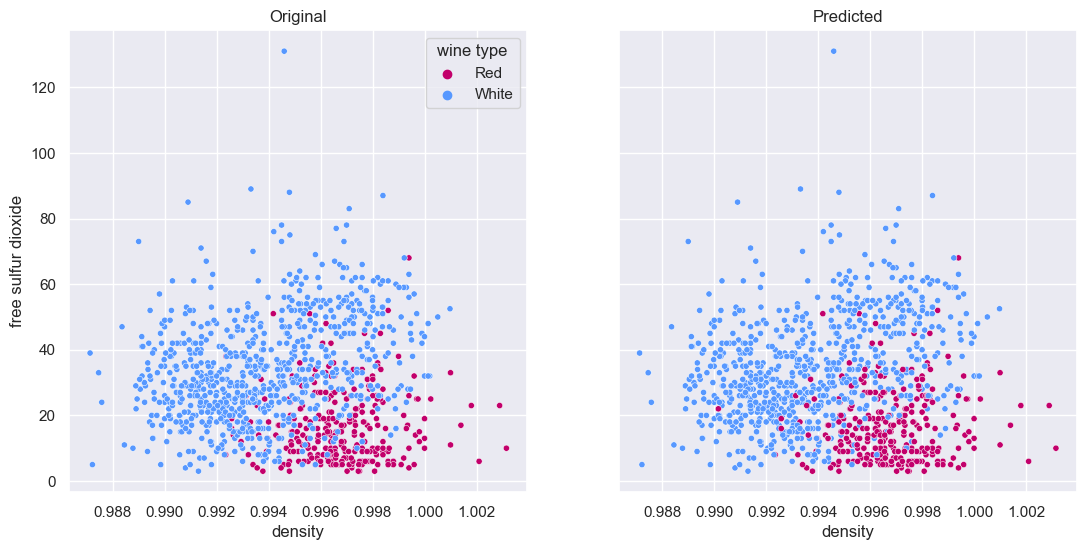

In [90]:
def predict_type(data):
    y = data["wine type"].cat.codes.copy()
    X = data.iloc[:, list(range(0, 8))].copy()
    # display(pd.concat([X, y], join='outer', axis=1))
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    pipe = Pipeline([
            ("scaler", QuantileTransformer()),
            ("model", LogisticRegression(max_iter=1000)),
        ])

    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    print(classification_report(pred, y_test))

    fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
    sns.scatterplot(
        x=data.iloc[:, 7],
        y=data.iloc[:, 5],
        hue=data["wine type"][y_test.index],
        ax=axes[0],
        palette=colors_w[::-1],
        s=20,
    )
    axes[0].set_title('Original')
    sns.scatterplot(
        x=X_test.iloc[:, 7],
        y=X_test.iloc[:, 5],
        hue=pred,
        ax=axes[1],
        palette=colors_w[::-1],
        s=20,
    )
    axes[1].set_title('Predicted')
    axes[1].legend([], [], frameon=False)

predict_type(wine)

In [91]:
def custom_precision(y_true, y_pred):
        precision = precision_score(y_true, y_pred)
        return precision if not np.isnan(precision) else 0

In [92]:
def resample(X ,y):

    high_count = y[y == 2].count()
    medium_count = y[y == 1].count()
    low_count = y[y == 0].count()

    under = RandomUnderSampler(sampling_strategy={1: int(medium_count * 0.8)}, random_state=42)
    over = SMOTE(sampling_strategy={0: low_count * 3, 2: high_count * 10}, random_state=42)
    sampling_pipe = pipeline.Pipeline([
        ('over', over),
        ('under', under)
    ])
    

    return sampling_pipe.fit_resample(X, y)
#     return SMOTEENN(sampling_strategy='not majority').fit_resample(X, y)
#     sampling_strategy={0: low_count * 3, 1: int(medium_count * 0.7), 2: high_count * 8}, 
    

In [93]:
def randomsearch(pipe):

    precision_scorer = make_scorer(precision_score)
    param_dist = {
        "model__n_estimators": randint(10, 200, 20),    # Number of trees in the forest
        "model__max_features": [
            "auto",
            "sqrt",
            "log2",
        ],                                              # Number of features to consider at each split
        "model__max_depth": randint(1, 20, 20),         # Maximum depth of the tree
        "model__min_samples_split": randint(
            2, 20, 10
        ),                                              # Minimum number of samples required to split an internal node
        "model__min_samples_leaf": randint(
            1, 20, 20
        ),                                              # Minimum number of samples required to be at a leaf node
        "model__bootstrap": [True, False],              # Whether bootstrap samples are used
        "model__criterion": ["gini", "entropy"],        # Split criterion
    }
    r_search = RandomizedSearchCV(
        estimator=pipe,                                 # Classifier to tune
        param_distributions=param_dist,                 # Hyperparameter distribution to sample from
        n_iter=100,                                     # Number of parameter settings to sample
        cv=5,                                           # Number of cross-validation folds
        verbose=1,                                      # Controls the verbosity: the higher, the more messages
        n_jobs=-1,                                      # Number of CPU cores to use (-1 means use all available cores)
        scoring='recall_score'
    )
    # grid = GridSearchCV(
    #     estimator=pipe,
    #     param_grid=param_grid,
    #     scoring=precision_scorer,
    #     return_train_score=True,
    #     cv=4,
    #     n_jobs=-1,
    # )
    return r_search


In [94]:
def choose_props(data):
    if data["wine type"][0] == "Red":
        X = data[[
                "alcohol", 
                "volatile acidity", 
                "citric acid", 
                "sulphates", 
                "chlorides"
            ]].copy()
        class_weight = {0: 2, 1: 1, 2: 2, 3: 1, 4: 1}
    else:
        X = data[[
                "alcohol",
                "volatile acidity",
                "chlorides",
                "density",
                "free sulfur dioxide",
            ]].copy()
        class_weight = {0: 3, 1: 2, 2: 2, 3: 2, 4: 1}
    
    return X, class_weight

In [95]:
def choose_model(model_name, cw):
    param_grid = {
        "n_estimators": 66,
        "min_samples_split": 7,
        "min_samples_leaf": 2,
        "max_features": "log2",
        "max_depth": 17,
        "criterion": "gini",
        "bootstrap": False,
    }
    param_grid_2 = {
        "n_estimators": 117,
        "min_samples_split": 4,
        "min_samples_leaf": 4,
        "max_features": "sqrt",
        "max_depth": 19,
        "criterion": "entropy",
        "bootstrap": False,
    }
    param_grid_3 = {
        "n_estimators": 138,
        "min_samples_split": 7,
        "min_samples_leaf": 3,
        "max_features": "sqrt",
        "max_depth": 19,
        "criterion": "gini",
        "bootstrap": False,
    }
    param_grid_4 = {
        "n_estimators": 146,
        "min_samples_split": 3,
        "min_samples_leaf": 2,
        "max_features": "log2",
        "max_depth": 19,
        "criterion": "entropy",
        "bootstrap": True,
    }
    if model_name == "svc":
        model = svm.SVC(class_weight=cw, gamma=10)
        param_grid = {"model__C": [5, 8, 10, 13, 15]}
    elif model_name == "kn":
        model = KNeighborsClassifier(n_neighbors=4)
        param_grid = {
            "model__n_neighbors": [4, 8, 12, 16],
            "model__weights": ["uniform", "distance"],
        }
    else:
        model = RandomForestClassifier(**param_grid_4, class_weight=cw, random_state=42)

    return model

In [96]:
def plot_prediction(data, X_test, y_test, pred):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    sns.scatterplot(
        y=data["alcohol"],
        x=data["volatile acidity"],
        hue=data["quality label"][y_test.index],
        palette=colors,
        ax=axes[0],
        s=25,
        linewidth=0,
    )
    axes[0].set_title("Original")
    sns.scatterplot(
        y=X_test["alcohol"],
        x=X_test["volatile acidity"],
        hue=pred,
        palette=colors,
        ax=axes[1],
        s=25,
        linewidth=0,
    )
    axes[1].set_title("Predicted")
    axes[1].legend([], [], frameon=False)
    plt.show()

In [97]:
def predict_quality(data, model_name, r_s, make_plot):

    y = data["quality label"].cat.codes.copy()
    X, class_weight = choose_props(data)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_resampled, y_train_resampled = resample(X_train, y_train)

    model = choose_model(model_name, class_weight)
    
    pipe = Pipeline([("scaler", MinMaxScaler()), ("model", model)])

    if r_s:
        r_search = randomsearch(pipe).fit(X_train_resampled, y_train_resampled)
        pred = r_search.predict(X_test)
        best_parameters = r_search.best_params_
        print(best_parameters)
    else:
        pipe.fit(X_train_resampled, y_train_resampled)
        pred = pipe.predict(X_test)
        
    # print(r_search.best_params_)
    # display(pd.DataFrame(r_search.cv_results_))
    # display(pd.DataFrame(grid.cv_results_))
    print(confusion_matrix(pred, y_test))
    print(f'F-1 Score: {f1_score(pred, y_test, average="weighted")}')
    print(classification_report(pred, y_test))
    
    if make_plot:
        plot_prediction(data, X_test, y_test, pred) 
        

[[  9  23   0]
 [ 26 660  25]
 [  0  45   5]]
F-1 Score: 0.8411726779557508
              precision    recall  f1-score   support

           0       0.26      0.28      0.27        32
           1       0.91      0.93      0.92       711
           2       0.17      0.10      0.12        50

    accuracy                           0.85       793
   macro avg       0.44      0.44      0.44       793
weighted avg       0.83      0.85      0.84       793



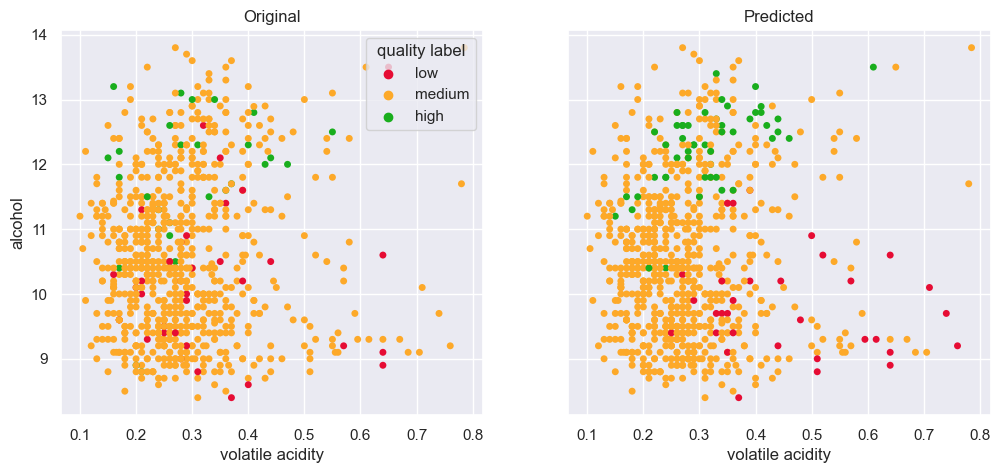

In [99]:
predict_quality(ww, 'r_forest', False, True)